<a href="https://colab.research.google.com/github/ahughe36/ml-final-project/blob/main/FinalProjectNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Cell RNA Classification and Clustering
## Introduction and Motivation
As in many other fields, big data plays an increasing role in medicine and biomedical research. Through single-cell RNA sequencing (scRNA-seq), scientists can analyze the levels of expression of different mRNA transcripts in individual cells. However, because much remains unknown about how the transcriptome influences the identity of any individual cell, it is not obvious how mRNA expression can be used to identify cell type. Therefore, we aim to use a variety of machine learning approaches to determine which works best for classifying/clustering ten different immune cell types on the basis of their transcriptomes. \\
There are a variety of benefits that medical practitioners and scientists would gain from the availability of a tool to rapidly identify cell type based on transcriptomics. For example, a pathologist could readily identify an imbalance in the proportion of one cell type over another, which could lead to a more accurate diagnosis (such as whether an infection is bacterial and needs antibiotics or is viral and will not improve with antibiotics) and more personalized medicine. From a research standpoint, many biomedical researchers who work with cells obtain RNA-seq for their samples but the large volume of data obtained makes it difficult ot analyze these results. Our efforts to apply Principal Component Analysis will reveal whether we can reduce the dimensionality of this dataset while still retaining a good characterization of the dataset. In terms of our primary objective, classifying and clustering our data based on cell types, our degree of success will indicate the degree to which transcriptomes can differentiate cell types. A high degree of accuracy on our classification apporaches may indicate that cell types are largely determined by each cell's transcriptome whereas a low degree of accuracy may indicate that the transcriptome is only a small part of identity and other factors, such as the protein expression that occurs downstream of transcription and translation, are more responsible for cell identity.
## Objectives
Must Accomplish:
- Implement logistic regression, Naive Bayes, neural network, and K-Nearest Neighbors
- Tune neural network parameters to optimize accuracy
- Compare the accuracy of different approaches to determine which is best

Expect to Accomplish:
- Implement K-Means Clustering
- Apply the best model to a novel dataset of immune cell scRNA-seq
- Use Principal Component Analysis to reduce the dimensionality and re-train the models on this dataset to compare performance

Hope to Accomplish:
- Use boosting to determine its effectiveness on this dataset
- Use Support Vector Machines to derive linear decision boundaries
- Simulate missing data via MCAR and MAR mechanisms to determine the robustness of our models to missing data

To access the data used in our project, please go to 
[https://drive.google.com/drive/folders/1YuIlTND_rsJ-KnxQa8v5uqu2mSf6nFPu?usp=sharing](https://drive.google.com/drive/folders/1YuIlTND_rsJ-KnxQa8v5uqu2mSf6nFPu?usp=sharing) and add the folder "ML Final Project" to "My Drive."


In [ ]:
# Loading the data: run this first before running any of the subsequent blocks
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir('/content/drive/MyDrive/ML Final Project/15% data')
import numpy as np
import scipy.sparse
Data = scipy.sparse.load_npz("pbmc10k.npz")
True_labels=np.load('pbmc10k_labels.npy')

Mounted at /content/drive


In [ ]:
# Common imports used for multiple code blocks: run this before running any of the subsequent blocks
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from google.colab import files
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split

##Some Exploratory Data Analysis
Before we begin our work with classification, it is helpful to understand what kidn of dataset we are working with. We checked the dimensionality of the data in proportion to the sample size, the distribution of class labels, and the average values of 10 randomly selected mRNA transcripts for each cell type.

(6840, 32738)
(6840, 10)


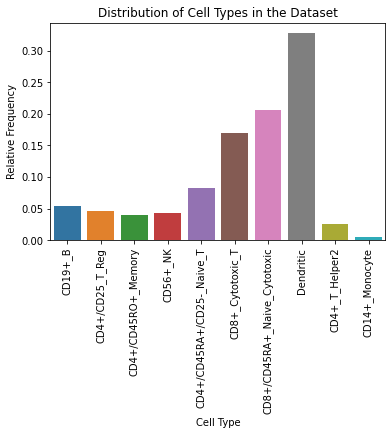

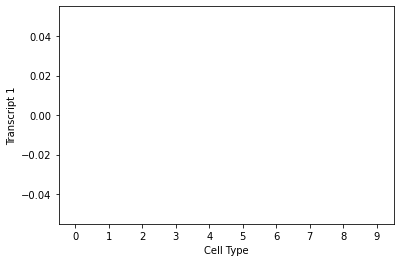

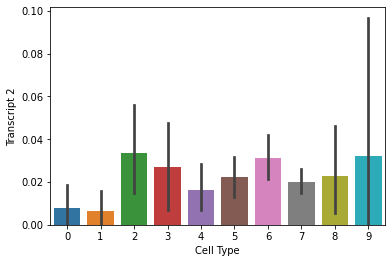

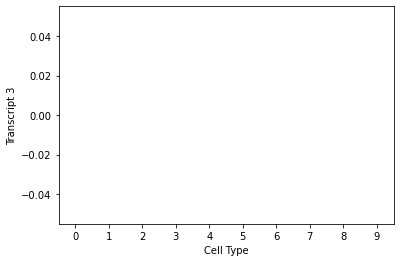

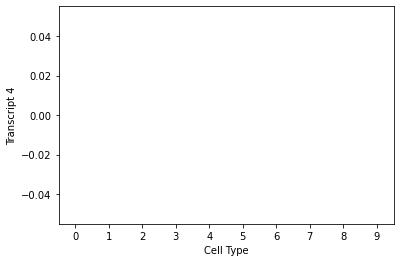

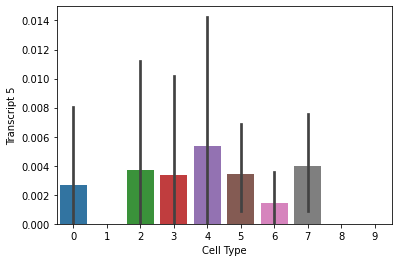

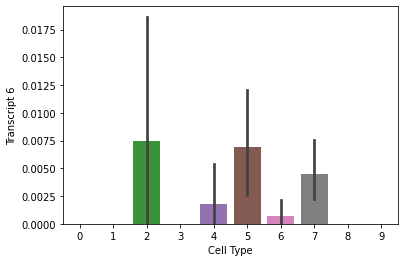

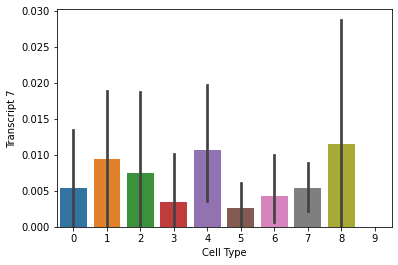

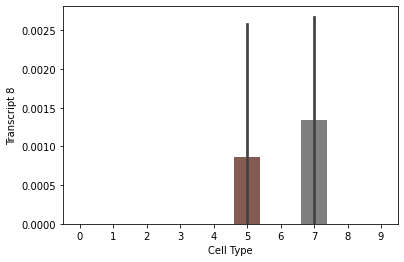

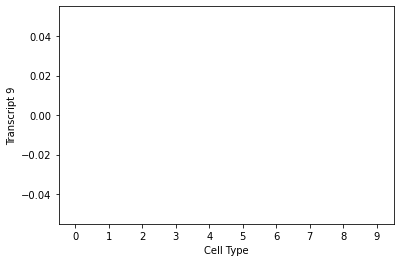

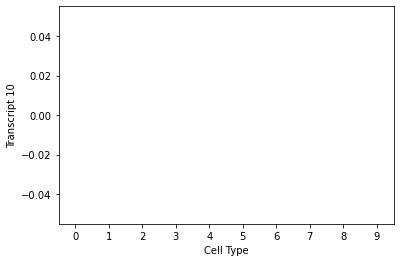

In [ ]:
print(Data.shape)
d = Data.toarray()
# Choose 10 transcripts at random to perform exploratory analysis
np.random.seed(12041999)
d = d[:, np.random.choice(d.shape[1], size=10, replace=False)]
print(d.shape)
cols = ['Transcript 1', 'Transcript 2', 'Transcript 3', 'Transcript 4', 'Transcript 5', 'Transcript 6', 'Transcript 7', 'Transcript 8', 'Transcript 9', 'Transcript 10']
df = pd.DataFrame(d, columns = cols)
df['Cell Type'] = True_labels
labels = ['CD19+_B', 'CD4+/CD25+_T_Reg', 'CD4+/CD45RO+_Memory', 'CD56+_NK', 'CD4+/CD45RA+/CD25-_Naive_T', 'CD8+_Cytotoxic_T', 'CD8+/CD45RA+_Naive_Cytotoxic', 'Dendritic', 'CD4+_T_Helper2', 'CD14+_Monocyte']
plt.figure()
count_arr = np.bincount(True_labels)
count_arr = count_arr / np.sum(count_arr)
ax = sns.barplot(x=labels, y=count_arr)
ax.set_xticklabels(labels=labels, rotation=90)
ax.set(xlabel ='Cell Type', ylabel='Relative Frequency', title='Distribution of Cell Types in the Dataset')
plt.show()
for col in cols:
    plt.figure()
    sns.barplot(x=df["Cell Type"], y = df[col])
    plt.show()

As we can see, the dataset has a very high dimension that is far greater than the sample size, with data for 32,738 RNA transcripts compared to only 6,840 cells sampled (these 6,840 examples are a 15% random subsample of the original, larger dataset). The dataset is also highly imbalanced, with dendritic cells comprising over 30% of the samples and CD14+ monocytes representing less than 1% of the samples. In analyzing the randomly sampled transcripts, we see that there are many transcripts that are not expressed in any of our samples, there are some in which transcripts are expressed in a few of the cell types at similar levels, and there are some that are expressed at comparable levels in almost all cell types. No one transcript stands out as being especially indicative of one type of cell due to the wide confidence intervals (the black bars on the seaborn bar plots are 95% confidence intervals).
## Must Accomplish
### Objective: Implement logistic regression, Naive Bayes, neural network, and K-Nearest Neighbors
#### Logistic Regression


In [ ]:
solvers=['lbfgs','liblinear', 'sag', 'saga']
X_train,X_test,y_train,y_test=train_test_split(Data,True_labels,test_size=0.2,random_state=0)
logreg_acc=[]
for i in solvers:
  logreg = LogisticRegression(solver=i)
  logreg.fit(X_train,y_train)
  y_pred=logreg.predict(X_test)
  logreg_acc.append(metrics.accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy for various solvers: [0.7090643274853801, 0.7141812865497076, 0.7375730994152047, 0.7368421052631579]


(0.7, 0.8)

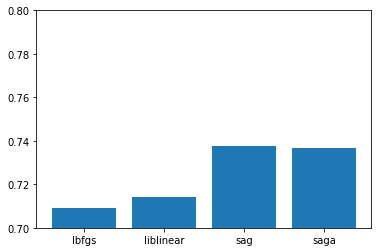

In [ ]:
print("Accuracy for various solvers:",logreg_acc)
plt.bar(solvers,logreg_acc)
plt.ylim([0.7,0.8])

In [ ]:
# Run this code block before any block that uses cross validation
#For classifiers, perform KFold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10,shuffle=True,random_state=42)

For our Naive Bayes classifiers, we tried three different approaches: Gaussian, Multinomial, and Complement Naive Bayes. The Gaussian Naive Bayes classifier assumes that the features follow normal distributions whereas the Multinomial and Complement Naive Bayes classifiers assume that the features follow a multinomial distribution. Complement Naive Bayes differs from Multinomial Naive Bayes in that it computes model weights based on the statistics of the complement of each class and is supposed to work better for imbalanced datasets. For each Naive Bayes classifier, we computed accuracy, 10-fold cross validation accuracy, and the confusion matrix.
####Gaussian Naive Bayes

Gaussian Naive Bayes Accuracy: 0.4137426900584795
Gaussian Naive Bayes Cross Validation Accuracy with 10 Folds:
[0.45321637 0.4122807  0.4005848  0.42251462 0.3874269  0.42690058
 0.4254386  0.40935673 0.42251462 0.45175439]


Text(32.093749999999986, 0.5, 'Actual')

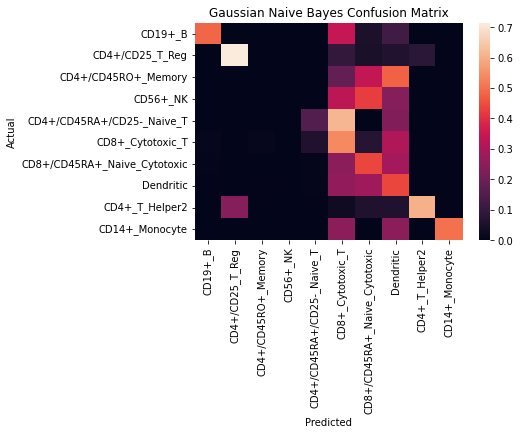

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train.toarray(), y_train)
naive_y_pred = gnb.predict(X_test.toarray())
print("Gaussian Naive Bayes Accuracy:",metrics.accuracy_score(y_test, naive_y_pred))
gnb_cm = metrics.confusion_matrix(y_test, naive_y_pred)
# Check accuracy with cross validation
print("Gaussian Naive Bayes Cross Validation Accuracy with 10 Folds:") 
print(cross_val_score(gnb, Data.toarray(), True_labels, cv=k_fold, scoring='accuracy'))
# Normalize confusion matrix
gnb_ncm = (gnb_cm.astype('float') / gnb_cm.sum(axis=1)[:, np.newaxis])
labels = ['CD19+_B', 'CD4+/CD25+_T_Reg', 'CD4+/CD45RO+_Memory', 'CD56+_NK', 'CD4+/CD45RA+/CD25-_Naive_T', 'CD8+_Cytotoxic_T', 'CD8+/CD45RA+_Naive_Cytotoxic', 'Dendritic', 'CD4+_T_Helper2', 'CD14+_Monocyte']
labeled_gnb_ncm = pd.DataFrame(gnb_ncm, index = labels, columns = labels)
plt.title('Gaussian Naive Bayes Confusion Matrix')
sns.heatmap(labeled_gnb_ncm, annot=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

####Multinomial Naive Bayes

Multinomial Naive Bayes Accuracy: 0.7317251461988304
Multinomial Naive Bayes Cross Validation Accuracy with 10 Folds:
[0.71929825 0.7251462  0.71929825 0.76315789 0.69736842 0.69736842
 0.72660819 0.70906433 0.72953216 0.75438596]


Text(32.093749999999986, 0.5, 'Actual')

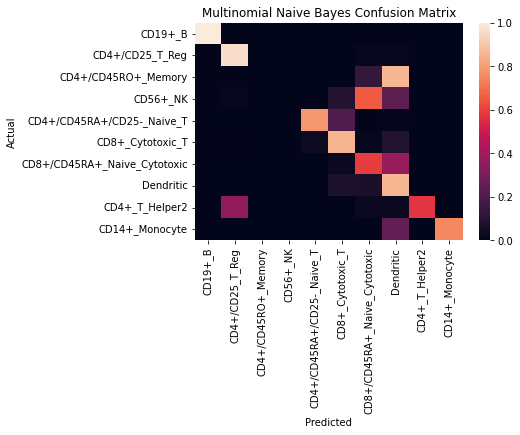

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb = mnb.fit(X_train.toarray(), y_train)
multi_naive_y_pred = mnb.predict(X_test.toarray())
print("Multinomial Naive Bayes Accuracy:",metrics.accuracy_score(y_test, multi_naive_y_pred))
mnb_cm = metrics.confusion_matrix(y_test, multi_naive_y_pred)
# Check accuracy with cross validation
print("Multinomial Naive Bayes Cross Validation Accuracy with 10 Folds:") 
print(cross_val_score(mnb, Data.toarray(), True_labels, cv=k_fold, scoring='accuracy'))
# Normalize confusion matrix
mnb_ncm = (mnb_cm.astype('float') / mnb_cm.sum(axis=1)[:, np.newaxis])
labeled_mnb_ncm = pd.DataFrame(mnb_ncm, index = labels, columns = labels)
plt.title('Multinomial Naive Bayes Confusion Matrix')
sns.heatmap(labeled_mnb_ncm, annot=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

####Complement Naive Bayes

Complement Naive Bayes Accuracy: 0.672514619883041
Complement Naive Bayes Cross Validation Accuracy with 10 Folds:
[0.64912281 0.66959064 0.63596491 0.70906433 0.62280702 0.65204678
 0.6622807  0.6505848  0.68567251 0.66666667]


Text(32.093749999999986, 0.5, 'Actual')

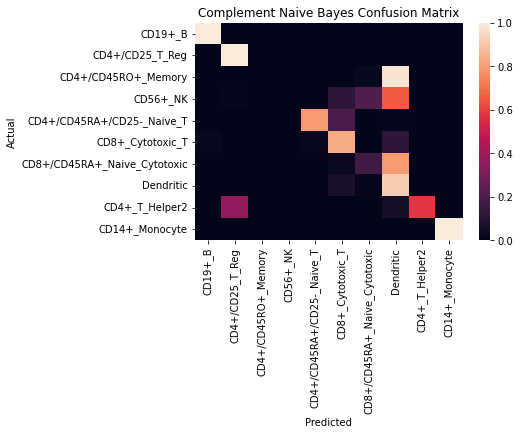

In [ ]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb = cnb.fit(X_train.toarray(), y_train)
comp_naive_y_pred = cnb.predict(X_test.toarray())
print("Complement Naive Bayes Accuracy:",metrics.accuracy_score(y_test, comp_naive_y_pred))
cnb_cm = metrics.confusion_matrix(y_test, comp_naive_y_pred)
# Check accuracy with cross validation
print("Complement Naive Bayes Cross Validation Accuracy with 10 Folds:") 
print(cross_val_score(cnb, Data.toarray(), True_labels, cv=k_fold, scoring='accuracy'))
# Normalize confusion matrix
cnb_ncm = (cnb_cm.astype('float') / cnb_cm.sum(axis=1)[:, np.newaxis])
labeled_cnb_ncm = pd.DataFrame(cnb_ncm, index = labels, columns = labels)
plt.title('Complement Naive Bayes Confusion Matrix')
sns.heatmap(labeled_cnb_ncm, annot=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

As we can see, Multinomial Naive Bayes had the highest model accuracy at 73.2%. All classifiers had cross validation accuracies that were within a few points of the test set accuracy, which indicates that these models are robust to overfitting on this dataset. All confusion matrices showed a similar pattern. While CD19+ B cells, CD4+/CD25+ T regulatory cell, dendritic cells, CD4+ T helper cells, and CD14+ monocytes show high classification accuracy, many other cell types are misclassified. Namely, these classifiers often confuse these other cell types for dendritic cells, which makes sense considering the imbalances in the dataset. Given that dendritic cells are the largest category of cell types, the classifier learns that it is usually a "safe bet" to classify a given cell type as a dendritic cell when its transcriptome is not distinctive enough to be classified as another cell type.

## Neural Network

Modified example from https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

We utilize a neural netowrk with 5 hidden layers with batchnorm and dropout at each layer. The network uses weighted random sampling in order to correct for class imbalances and conduct multiple hyper parameter sweeps based on optimizing learning rate, batch size and drop out rates in order to improve the overall accuracy.


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler   
from sklearn.metrics import classification_report

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
Data_new = Data.toarray()
X_trainval, X_test, y_trainval, y_test = train_test_split(Data_new, True_labels, test_size=0.2, stratify=True_labels, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
def class_dist(obj):
    counts = {
        "CD19+_B": 0,
        "CD4+/CD25_T_Reg": 0,
        "CD4+/CD45RO+_Memory": 0,
        "CD56+_NK": 0,
        "CD4+/CD45RA+/CD25-_Naive_T": 0,
        "CD8+_Cytotoxic_T": 0,
        "CD8+/CD45RA+_Naive_Cytotoxic": 0,
        "Dendritic": 0,
        "CD4+_T_Helper2": 0,
        "CD14+_Monocyte": 0,
    }
    
    for i in obj:
        if i == 0: 
            counts['CD19+_B'] += 1
        elif i == 1: 
            counts['CD4+/CD25_T_Reg'] += 1
        elif i == 2: 
            counts['CD4+/CD45RO+_Memory'] += 1
        elif i == 3: 
            counts['CD56+_NK'] += 1
        elif i == 4: 
            counts['CD4+/CD45RA+/CD25-_Naive_T'] += 1  
        elif i == 5: 
            counts['CD8+_Cytotoxic_T'] += 1
        elif i == 6: 
            counts['CD8+/CD45RA+_Naive_Cytotoxic'] += 1  
        elif i == 7: 
            counts['Dendritic'] += 1 
        elif i == 8: 
            counts['CD4+_T_Helper2'] += 1   
        elif i == 9: 
            counts['CD14+_Monocyte'] += 1             
        else:
            print("Check classes.")
            
    return counts

Text(0.5, 1.0, 'Class Distribution in Test Set')

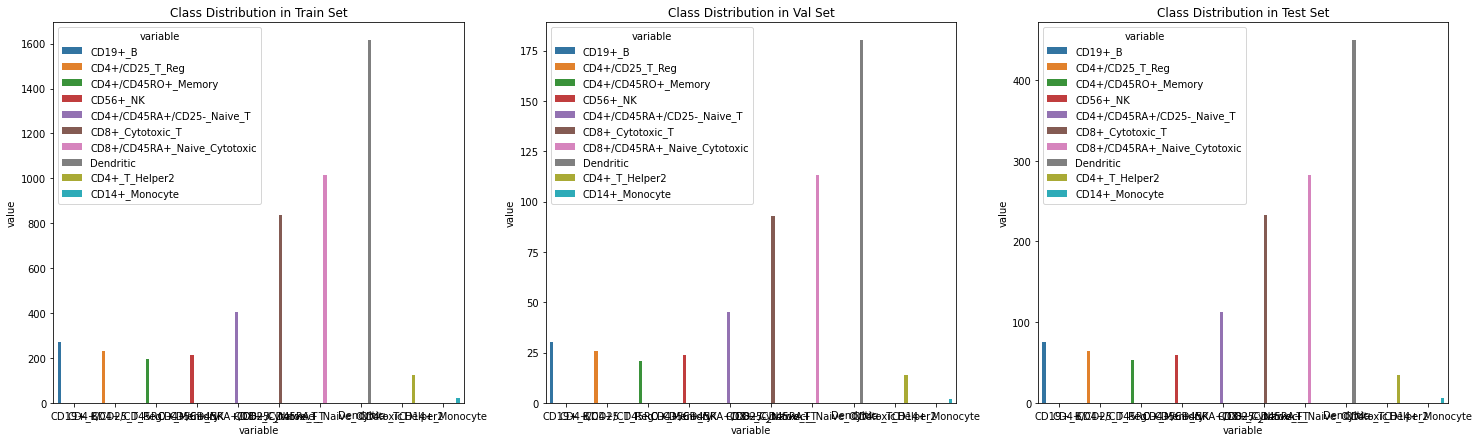

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([class_dist(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([class_dist(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([class_dist(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


Note that the class distribution is massively imbalanced this is why we use weighted random sampling in order to minimize the impacts of the imbalance on classification. 

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

class_count = [i for i in class_dist(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)
class_weights_all = class_weights[target_list]


tensor([0.0037, 0.0044, 0.0052, 0.0047, 0.0025, 0.0012, 0.0010, 0.0006, 0.0080,
        0.0435])


This code helps us set up a set of class weights by creating a target list to which these are appended

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [ ]:
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_FEATURES = len(Data.toarray()[0])

NUM_CLASSES = 10

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class ClassiferMulti(nn.Module):
    def __init__(self, num_feature, num_class):
        super(ClassiferMulti, self).__init__()
        
        self.firstLayer = nn.Linear(num_feature, 8192)
        self.secondLayer = nn.Linear(8192, 512)
        self.thirdLayer = nn.Linear(512,128)
        self.fourthLayer = nn.Linear(128, 32)
        self.output = nn.Linear(32, num_class) 
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(8192)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(32)

        
    def forward(self, x):
        x = self.firstLayer(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.secondLayer(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.drop(x)
        
        x = self.thirdLayer(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.drop(x)

        x = self.fourthLayer(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.drop(x)
        
        x = self.output(x)
        
        return x

This defines the set up of the hidden layers in the neural network. Each layer linearizes to a smaller number of features and then outputs for the number of classes.

In [ ]:
model = ClassiferMulti(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def accuracy_multi(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
for e in range(1, EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = accuracy_multi(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = accuracy_multi(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                                
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Epoch 001: | Train Loss: 1.33801 | Val Loss: 2.05777 | Train Acc: 40.279| Val Acc: 41.058
Epoch 002: | Train Loss: 0.84783 | Val Loss: 2.03837 | Train Acc: 62.805| Val Acc: 35.766
Epoch 003: | Train Loss: 0.61957 | Val Loss: 2.05735 | Train Acc: 69.851| Val Acc: 25.182
Epoch 004: | Train Loss: 0.52452 | Val Loss: 2.05313 | Train Acc: 70.273| Val Acc: 24.088
Epoch 005: | Train Loss: 0.42735 | Val Loss: 2.03595 | Train Acc: 70.312| Val Acc: 23.358
Epoch 006: | Train Loss: 0.36688 | Val Loss: 2.01090 | Train Acc: 69.130| Val Acc: 22.080
Epoch 007: | Train Loss: 0.32058 | Val Loss: 1.99490 | Train Acc: 69.805| Val Acc: 22.810
Epoch 008: | Train Loss: 0.28346 | Val Loss: 1.97242 | Train Acc: 69.740| Val Acc: 22.628
Epoch 009: | Train Loss: 0.26432 | Val Loss: 1.95087 | Train Acc: 69.026| Val Acc: 23.358
Epoch 010: | Train Loss: 0.24384 | Val Loss: 1.93572 | Train Acc: 70.630| Val Acc: 23.358
Epoch 011: | Train Loss: 0.21321 | Val Loss: 1.92007 | Train Acc: 71.292| Val Acc: 22.628
Epoch 012:

This defines the training loop for our network. We loop across the number of epochs in order to train the network and then append our values 

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.94      0.99      0.96        75
           1       0.83      1.00      0.91        64
           2       0.00      0.00      0.00        53
           3       0.50      0.07      0.12        59
           4       0.84      0.79      0.82       112
           5       0.72      0.72      0.72       233
           6       0.33      0.96      0.49       282
           7       0.00      0.00      0.00       449
           8       1.00      0.51      0.68        35
           9       1.00      0.83      0.91         6

    accuracy                           0.51      1368
   macro avg       0.62      0.59      0.56      1368
weighted avg       0.40      0.51      0.41      1368



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Objective: Tune neural network parameters to optimize accuracy

Here we tune our neural network by running parameter sweeps for 4 different features: learning rate, batch size, number of features, and drop out rate.

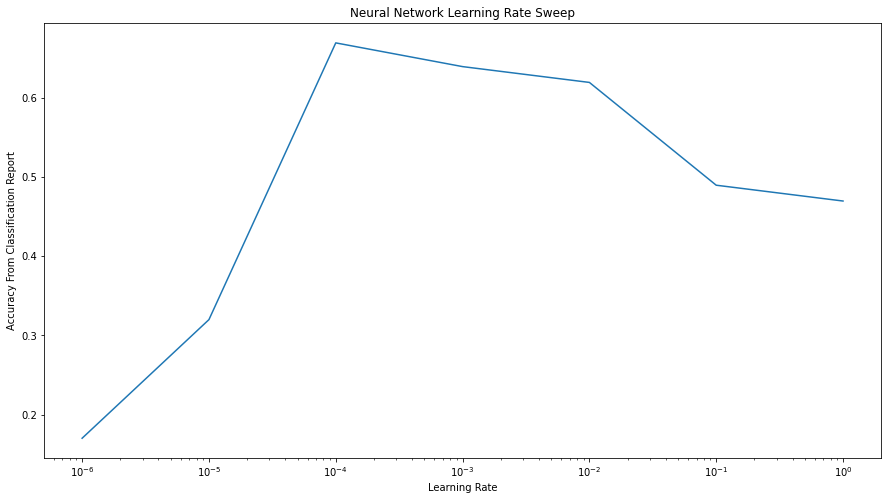

In [ ]:
learning_rates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
df = pd.DataFrame(data=[0.17, 0.32, 0.67, 0.64, 0.62, 0.49, 0.47])
df.to_csv('sweep.csv')
simple_ff_metrics = pd.read_csv('sweep.csv')
dev_acc = simple_ff_metrics.iloc[:,1]
plt.figure(figsize=(15, 8))
plt.title("Neural Network Learning Rate Sweep")
ax = plt.gca()
plt.plot(learning_rates,dev_acc)
ax.set_xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy From Classification Report')
plt.show()
#Optimal Learning Rate is 10^-4

We sweep across the learning rates using values of [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]. Ultimately the value yielding the best accuracy is 10^-*4*

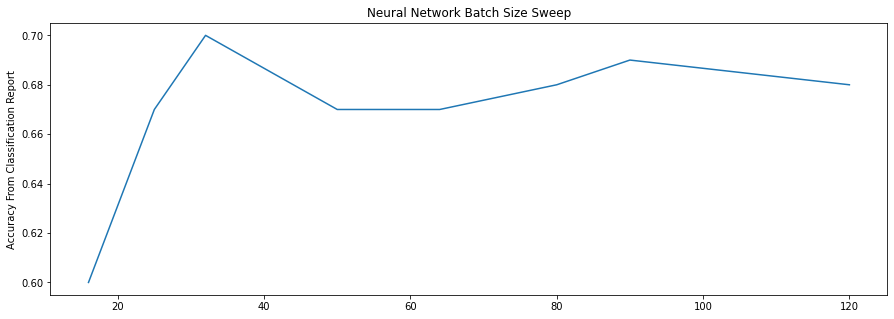

In [ ]:
batch_sizes = [16,25,32,50,64,80,90,120]
df = pd.DataFrame(data=[0.6,0.67, 0.7, 0.67, 0.67, 0.68, 0.69, 0.68])
df.to_csv('sweep.csv')
batch_size_metrics = pd.read_csv('sweep.csv') 
dev_acc = batch_size_metrics.iloc[:,1]
plt.figure(figsize=(15, 5))
plt.title("Neural Network Batch Size Sweep")
ax = plt.gca() 
plt.plot(batch_sizes, dev_acc) 
plt.ylabel('Accuracy From Classification Report')
plt.show()
#Optimal batch size is 32

While holding the leaarning rate constant we sweep across the batch sizes using [16,25,32,50,64,80,90,120]. Ultimately we get our best batch size of 32 during this sweep.

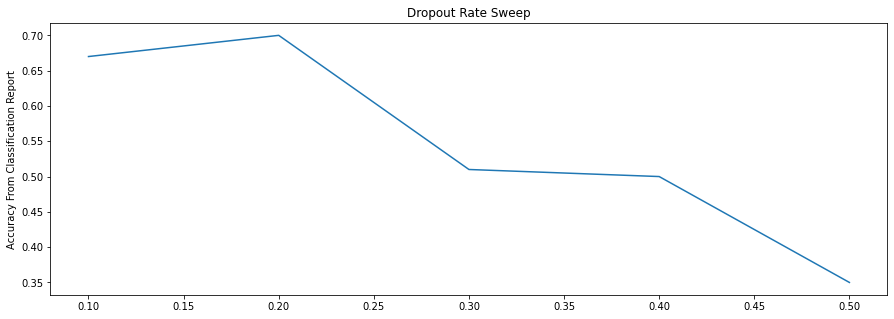

In [ ]:
dropout = [0.1,0.2,0.3,0.4,0.5]
df = pd.DataFrame(data=[0.67,0.7, 0.51, 0.5, 0.35])
df.to_csv('sweep.csv')
batch_size_metrics = pd.read_csv('sweep.csv') 
dev_acc = batch_size_metrics.iloc[:,1]
plt.figure(figsize=(15, 5))
plt.title("Dropout Rate Sweep")
ax = plt.gca() 
plt.plot(dropout, dev_acc) 
plt.ylabel('Accuracy From Classification Report')
plt.show()
#Optimal dropout rate is 0.2

While holding the previous 2 parameters, constant we engage in a dropout sweep using values [0.1,0.2,0.3,0.4,0.5]. The best value is achieved at 0.2.

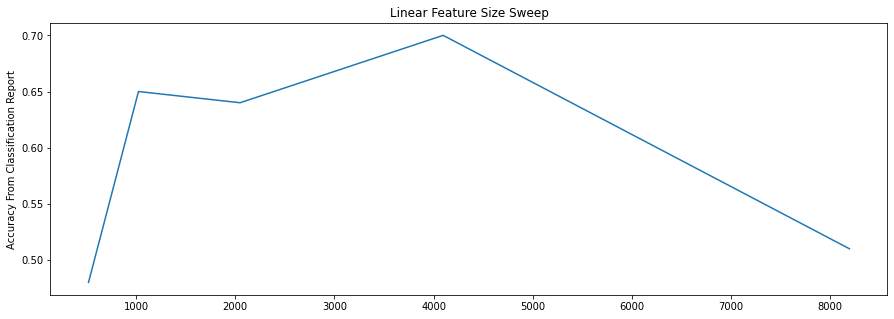

In [ ]:
number_of_linear_features_in_1st_fully_connected_layer = [520, 1024, 2048, 4096, 8192]
df = pd.DataFrame(data=[0.48, 0.65, 0.64, 0.7, 0.51])
df.to_csv('sweep.csv')
best_linear_metrics = pd.read_csv('sweep.csv') 
dev_acc = best_linear_metrics.iloc[:,1]
plt.figure(figsize=(15, 5))
plt.title("Linear Feature Size Sweep")
ax = plt.gca() 
plt.plot(number_of_linear_features_in_1st_fully_connected_layer, dev_acc) 
plt.ylabel('Accuracy From Classification Report')
plt.show()
# Valid range between 10 and infinity
# The larger the feature size, the better until the number of linear-features is larger than the
# number of inputs into the linear layer. There is also a large time tradeoff.

While holding the previous 3 parameters, constant we engage in a dropout sweep using values [520, 1024, 2048, 4096, 8192]. The best value is achieved at 4096 parameters.

Based on hyper parameter sweeps our neural network demonstrates an ideal learning rate of 0.0001, an optimal batchsize of 32, an optimal number of linear features in first hidden layer of 4096, and an optimal dropout rate of 0.2. We get a maximal accuracy of roughly 70% based on our combined hyperparameters. For future goals we think that tuning multiple hyperparameters together could help improve accuracy however this was not done here due to a lack of available computing power. 
#### K-Nearest Neighbors

In [ ]:
#knn
k=[1,5,10,20,40,60]
from sklearn.neighbors import KNeighborsClassifier
accuracy=[]
std=[]
for i in k:
  knn = KNeighborsClassifier(n_neighbors=i)
  scores = cross_val_score(knn, Data, True_labels, cv=k_fold, scoring='accuracy')
  accuracy.append(np.mean(scores))
  std.append(np.std(scores))

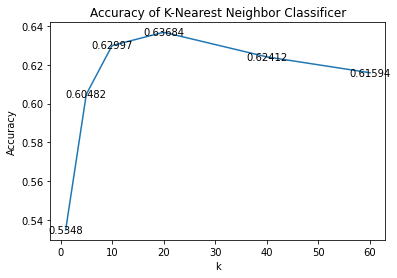

In [ ]:
plt.plot(k, accuracy)
for i_x, i_y in zip(k, accuracy):
    plt.text(i_x, i_y, '{}'.format(np.round(i_y,5)), ha="center", va="center")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of K-Nearest Neighbor Classificer')
plt.savefig("knn.png")
files.download("knn.png") 
plt.show()


We tested knn classifier with different k, and found the accuracy is the highest when k=20. When the k is too small, the most frequent label might not be the true label. When k is too large, the area of the nearest neighbors becomes too large.

In [ ]:
#KMeans
from sklearn.cluster import KMeans
k=[1,5,10,20,40,60]
ari_score=[]
for i in k:
  kmeans = KMeans(n_clusters=i,).fit(Data)
  kmeans_label=kmeans.labels_
  ari_score.append(adjusted_rand_score(kmeans_label,True_labels))

In [ ]:
#KMeans++
from sklearn.cluster import KMeans
ari_scoreplus=[]
for i in k:
  kmeans = KMeans(n_clusters=i,init='k-means++').fit(Data)
  kmeans_label=kmeans.labels_
  ari_score.append(adjusted_rand_score(kmeans_label,True_labels))

Text(0.5, 1.0, 'kmeans ARI score')

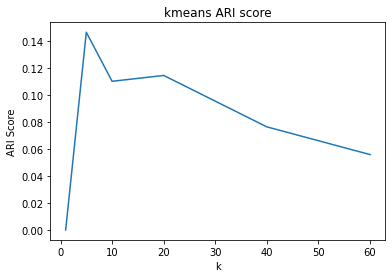

In [ ]:
plt.plot(k,ari_score)
plt.xlabel('k')
plt.ylabel('ARI Score')
plt.title('kmeans ARI score')

Text(0.5, 1.0, 'kmeans++ ARI score')

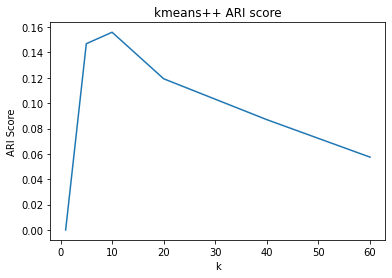

In [ ]:
plt.plot(k,ari_score[6:12])
plt.xlabel('k')
plt.ylabel('ARI Score')
plt.title('kmeans++ ARI score')

We used ARI score to assess the performance of clustering algorithms. It measures the similarity between predicted labels and true labels. We notice that kmeans can perform not so well with poor center initialization. So there is an improved k-means++ method that solves this issue by spreading out the k initial centers. As shown by the graphs, we tested the two methods with different values for k, the number of clusters. We noticed that there is the unusual dip in kmeans graph at k=10, this is probably due to poor initialization, while kmeans++ doesnt have such issue.


In [ ]:
#DBScan
from sklearn.cluster import DBSCAN
eps=[1,100,500,1000]
ari_score_DB=[]
for i in eps:
  sc = DBSCAN(eps=i).fit(Data)
  ari_score_DB.append(adjusted_rand_score(sc.labels_,True_labels))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

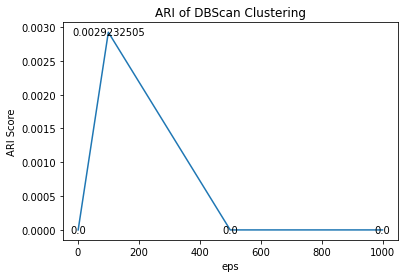

In [ ]:
plt.plot(eps, ari_score_DB)
for i_x, i_y in zip(eps, ari_score_DB):
    plt.text(i_x, i_y, '{}'.format(np.round(i_y,10)), ha="center", va="center")
plt.xlabel('eps')
plt.ylabel('ARI Score')
plt.title('ARI of DBScan Clustering')
plt.savefig("DBScan.png")
files.download("DBScan.png") 
plt.show()

It uses the epsilon value that is one of the parameters we can control. A point within the epsilon range of another point is within the same cluster as the other. However, since our dataset has so many dimensions, the euclidean distances between points are not so clear so as shown by the graph, no matter what epsilon we set, it does not perform well.


In [ ]:
#Spectral Clustering
from sklearn.cluster import SpectralClustering
nn=[10,20,40,60]
ari_score_sc=[]
for i in eps:
  sc = SpectralClustering(n_clusters=10,affinity='nearest_neighbors',n_neighbors=i).fit(Data)
  ari_score_sc.append(adjusted_rand_score(sc.labels_,True_labels))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

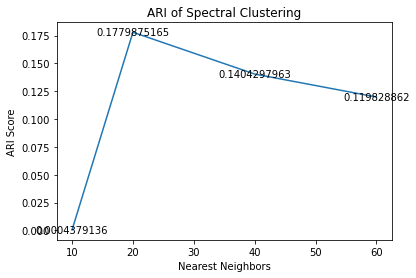

In [ ]:
plt.plot(nn, ari_score_sc)
for i_x, i_y in zip(nn, ari_score_sc):
    plt.text(i_x, i_y, '{}'.format(np.round(i_y,10)), ha="center", va="center")
plt.xlabel('Nearest Neighbors')
plt.ylabel('ARI Score')
plt.title('ARI of Spectral Clustering')
plt.savefig("Spectral.png")
files.download("Spectral.png") 
plt.show()

This is a method that uses k-nearest neighbor matrix as a graph representation and reduces dimensions before running kmeans. It does perform better, but more computationally expensive, so we use kmeans++ for future tests.


###Ridge Classification

We implemented a ridge classifier to check for accuracy however his performed quite poorly yileding around 58% accuracy

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(Data,True_labels,test_size=0.2,random_state=0)
from sklearn.linear_model import RidgeClassifier
Ridgereg = RidgeClassifier()
Ridgereg.fit(X_train,y_train)
y_pred=Ridgereg.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Confusion matrix") 
print(metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.570906432748538
Confusion matrix
[[ 52   0   2   0   0   0   1   3   0   0]
 [  0  48   0   0   1   2   8   3   1   0]
 [  0   0   3   1   0   4  12  24   0   0]
 [  1   0   6   6   1  16  25  20   0   0]
 [  0   0   0   1  75  26   3   7   0   0]
 [  4   1   5   3  11 147  29  37   0   0]
 [  0   1  13  16   1   8 124  98   0   0]
 [  0   0  20   6   0  45  98 312   0   0]
 [  0  10   1   0   0   2   4   5  11   0]
 [  0   0   0   0   0   1   0   0   0   3]]


This confusion matrix demonstrates that ridge regression generally picks the safe bet of dediatric cell classification.

###Decision Tree Classifier

Decision tree classification is a technique which iteratively splits our data set based on a number of "questions" to it.
Here we implement a decision tree classifier with a maximum depth of 51 on our data set. 

Best prediction score 0.7244152046783626
Depth 10


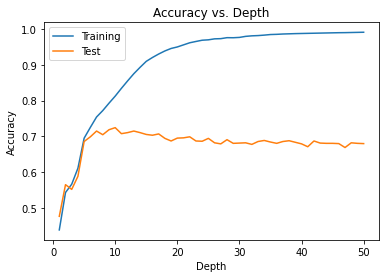

In [ ]:
# Decision Tree Classifier 
from sklearn import tree 

# Choosing optimal depth 
depth = np.arange(1, 51, 1)
accuracy_train = []
accuracy_test = []

for max_depth in range (1, 51):
  clf = tree.DecisionTreeClassifier(max_depth = max_depth, random_state = 42)
  clf.fit(X_train, y_train)
  pred_train = clf.predict(X_train)
  pred_test = clf.predict(X_test)
  accuracy_train.append(accuracy_score(pred_train, y_train))
  accuracy_test.append(accuracy_score(pred_test, y_test))

print("Best prediction score", max(accuracy_test))
print("Depth", depth[accuracy_test.index(max(accuracy_test))])

plt.plot(depth, accuracy_train, label = "Training")
plt.plot(depth, accuracy_test, label = "Test")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Depth")
plt.legend()
plt.show()

As seen above the best prediction score happens at a depth of 10 with an accuracy of roughly 72%. Beyond this accuracy slowly seems to decrease over time which may be due to overfitting.

### Objective: Compare the accuracy of different approaches to determine which is best
The classifer with the best accuracy score was gradient boosting, with an accuracy of 76.5%. However, logistic regression with the SAGA solver also had a high accuracy (73.8%) and was less computationally expensive.

## Expect to Accomplish



### Objective: Apply the best model to a novel dataset of immune cell scRNA-seq

New Dataset: t293

In [ ]:
os.chdir('/content/drive/MyDrive/ML Final Project/293t')
t293 = scipy.sparse.load_npz("293t.npz")
with open('293t_labels.txt') as f:
  t293_label=f.readlines()
t293_label=t293_label[0].replace('\n','').split(',')


In [ ]:
print(t293_label)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

### Objective: Implement K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
k=[2]
ari_score=[]
for i in k:
  kmeans = KMeans(n_clusters=i,init='k-means++').fit(t293)
  kmeans_label=kmeans.labels_
  from sklearn.metrics.cluster import adjusted_rand_score
  ari_score.append(adjusted_rand_score(kmeans_label,t293_label))

In [ ]:
print(ari_score)

[0.015000528426708418]


The kmeans++ performance for the new dataset is really horrible due to unbalanceness

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(t293,t293_label,test_size=0.5,random_state=0)
logreg = LogisticRegression(solver='saga',max_iter=1000)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.9990444338270426


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression did really well, probably because even if it classified all points to be 1's, it is still going to have a good accuracy.

### Objective: Use Principal Component Analysis to reduce the dimensionality and re-train the models on this dataset to compare performance

In [ ]:
def normalize(x):
  return (x - np.mean(x)) / np.std(x)
NormalizedX = normalize(Data.toarray())
feat_cols = ['feature'+str(i) for i in range(NormalizedX.shape[1])]
normalisedX = pd.DataFrame(NormalizedX,columns=feat_cols)
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(normalisedX)
print('PCA eigenvalues and most important features')
print(pca.explained_variance_ratio_)
print(np.argmax(pca.components_,axis=1))
arr = pca.components_[0,:]
idx = (-arr).argsort()[:10]
print('10 Most important features for PC1')
print(idx,arr[idx])
#print(pca.components_[0,np.argmax(pca.components_,axis=1)[0]])
#print(pca.components_[1,np.argmax(pca.components_,axis=1)[1]])

PCA eigenvalues and most important features
[0.34484195 0.08696622 0.06029355 0.03254611 0.02644643 0.01185192
 0.00975163 0.00908697 0.008023   0.00761201]
[24673 13302  9798 23794  9798 13302  4046 31682 13302 31682]
10 Most important features for PC1
[24673 26013 14247 30970 15745 19154 13731 32022 10709 19420] [0.27279525 0.26640213 0.23031911 0.20551017 0.20377302 0.19389161
 0.17634371 0.17215348 0.17038259 0.15121038]


We also performed PCA to try to reduce the feature space to 10. However we see by the explained variance, the first 10 can’t represent the majority of the dataset. 


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(principalComponents,True_labels,test_size=0.2,random_state=0)
logreg = LogisticRegression(solver='saga',max_iter=1000)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6812865497076024


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,init='k-means++').fit(principalComponents)
kmeans_label=kmeans.labels_
print(adjusted_rand_score(kmeans_label,True_labels))
    

0.03537108947343971


This is shown with the test we conducted with kmeans and logistics regression, as both performed worse.

## Hope to Accomplish

### Objective: Use boosting to determine its effectiveness on this dataset
####Gradient Boosting Classifier
The following code utilizes a boosting algorithm in order to create a "strong" learner from a number of weak learners. Because the computation time is extensive we utilize a small number of estimators (25) although we would have liked to use more roughly around the 100-200 mark for best results. We also sweep across a number of learning rates for the best possible results. 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
X_train,X_test,y_train,y_test=train_test_split(Data,True_labels,test_size=0.2,random_state=0)

In [ ]:
lr_tests = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]

train_acc_est = [[] for i in lr_tests]
test_acc_est = [[] for i in lr_tests]


for est in range(1,25,1): 
  print(est)
  for i in range(len(lr_tests)):
    lr = lr_tests[i]
    model = GradientBoostingClassifier(n_estimators= est, learning_rate = lr, random_state=42).fit(X_train, np.ravel(y_train))
    train_acc_est[i].append(model.score(X_train, y_train))
    test_acc_est[i].append(model.score(X_test, y_test))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


---------------------------------------------------------
Best Test Prediction Accuracy Model Statistics:  
 

Test Prediction Accuracy:  0.7654
Learning Rate:  0.2
Number of Estimators:  18
---------------------------------------------------------

LR:  0.001
Best Test Prediction Accuracy:  0.3516
Best Number of Estimators:  1


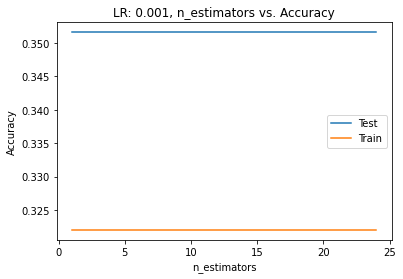

LR:  0.01
Best Test Prediction Accuracy:  0.5819
Best Number of Estimators:  24


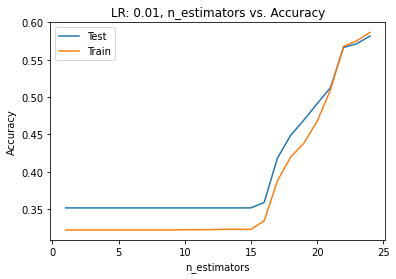

LR:  0.1
Best Test Prediction Accuracy:  0.7610
Best Number of Estimators:  22


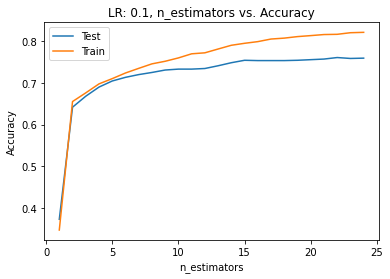

LR:  0.2
Best Test Prediction Accuracy:  0.7654
Best Number of Estimators:  18


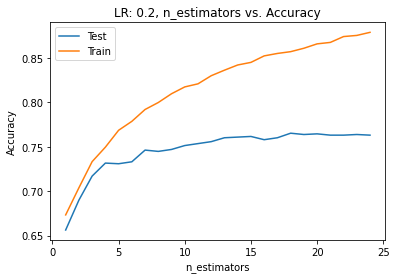

LR:  0.5
Best Test Prediction Accuracy:  0.7273
Best Number of Estimators:  3


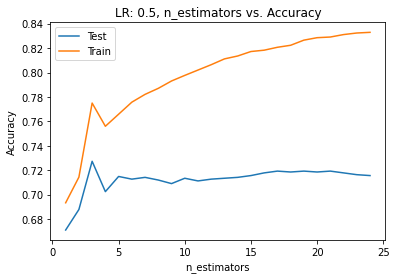

LR:  0.7
Best Test Prediction Accuracy:  0.7325
Best Number of Estimators:  3


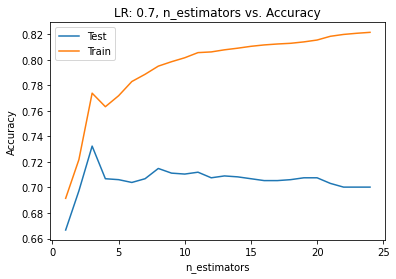

LR:  1
Best Test Prediction Accuracy:  0.7208
Best Number of Estimators:  6


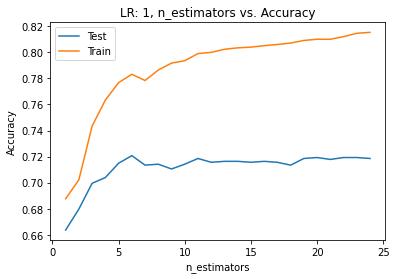

In [ ]:
max_test = [max(test_temp) for test_temp in test_acc_est]
best_stat_ind = max_test.index(max(max_test))
best_stat_lr = lr_tests[best_stat_ind]

print("---------------------------------------------------------")
print("Best Test Prediction Accuracy Model Statistics:  \n \n") 
print("Test Prediction Accuracy: ", format(max(max_test), '.4f')) 
print("Learning Rate: ", best_stat_lr) 
print("Number of Estimators: ", range(1,25,1)[test_acc_est[best_stat_ind].index(max(test_acc_est[best_stat_ind]))])
print("---------------------------------------------------------\n")

for i in range(len(lr_tests)):
  lr = lr_tests[i]
  print("LR: ", lr)
  print("Best Test Prediction Accuracy: ", format(max(test_acc_est[i]), '.4f'))
  print("Best Number of Estimators: ", range(1,25,1)[test_acc_est[i].index(max(test_acc_est[i]))])
  plt.plot(range(1,25,1), test_acc_est[i], label = "Test")
  plt.plot(range(1,25,1), train_acc_est[i], label = "Train")
  plt.xlabel('n_estimators')
  plt.ylabel('Accuracy')
  title_str = 'LR: ' + str(lr) + ', n_estimators vs. Accuracy'
  plt.title(title_str)
  plt.legend()
  plt.show()

The above graphs and results demonstrate that the best accuracy is achieved at a learning rate of 0.2 with 18 estimators. Interestingly, it isn't always the case that accuracy increases with the number of learners but rather at some points there is a decrease is over all accuracy (particularly for higher learning rates) with more estimators. 
Note that this graph also highlights the flaw in our experiment. For smaller learning rates particularly in the case of 0.1 it seems that the accuracy is still increasing, however due to a lack of computation time we had to stop the experiment here. 

### Objective: Simulate missing data via MCAR and MAR mechanisms to determine the robustness of our models to missing data
We chose to simulate MCAR and MAR mechanisms for missing data, as they are more tractable to deal with than MNAR datasets. We use pre-existing libraries developed by the ML community to generate the MCAR and MNAR datasets and we chose to make 10% of the data missing, which is represented in the new datasets as NaN.

In [ ]:
# This block will generate the MCAR dataset. The MAR dataset takes several hours
# to generate, so you have a choice of running both this block and the 
# subsequent one to generate both the MCAR and MAR datasets from scratch, or 
# run both this block and the block after next to generate the MCAR dataset from
# scratch and load a pre-generated MAR dataset from an .npy file.
# Modified example from https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values
!pip install wget 
import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')
from utils import *
def produce_NA(X, p_miss, mecha, p_obs=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" or "MAR"
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}
  
X_miss_mcar = produce_NA(Data.toarray(), p_miss=0.1, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

X_mcar_np = np.array(X_mcar)

print("Percentage of generated missing values for MCAR: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")


Percentage of generated missing values for MCAR:  10.002059591318492  %


In [ ]:
# Run this block to generate the MAR dataset from scratch
X_miss_mar = produce_NA(Data.toarray(), p_miss=0.1, mecha="MAR", p_obs=0.5)

X_mar = X_miss_mar['X_incomp']
R_mar = X_miss_mar['mask']

X_mar_np = np.array(X_mar)

print("Percentage of generated missing values for MAR: ", (R_mar.sum()).numpy()/np.prod(R_mar.size())*100, " %")

In [ ]:
# Run this block to load a pre-generated MAR dataset
os.chdir('/content/drive/MyDrive/ML Final Project/15% data')
X_mar_np = np.load('mar.npy')

The following code blocks test the performance of the logistic regression model with the 'saga' solver on the MCAR and MAR datasets to determine whether missing data and the method of missing value imputation affect the accuracy (baseline 73.8%). We chose to use the logisitc regression model because it had a relatively high accuracy and ran faster than the neural network, even though the neural network sometimes achieved better accuracy in some of our test runs. The imputation block should be run before any of the subsequent blocks, which are separated since each models takes a few hours to train.

In [ ]:
# Impute the data for MCAR and MAR datasets using the mean and median-based
# strategies
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
Data_mcar_imp_mean = imp.fit_transform(X_mcar_np, True_labels)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
Data_mcar_imp_med = imp.fit_transform(X_mcar_np, True_labels)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
Data_mar_imp_mean = imp.fit_transform(X_mar_np, True_labels)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
Data_mar_imp_med = imp.fit_transform(X_mar_np, True_labels)

In [ ]:
# Logistic Regression with 'Saga' Solver run on Mean-Imputed MCAR Dataset
X_train,X_test,y_train,y_test=train_test_split(Data_mcar_imp_mean,True_labels,test_size=0.2,random_state=0)
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Logistic Regression Accuracy with Mean Imputation on MCAR:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Logistic Regression with 'Saga' Solver run on Median-Imputed MCAR Dataset
X_train,X_test,y_train,y_test=train_test_split(Data_mcar_imp_med,True_labels,test_size=0.2,random_state=0)
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Logistic Regression Accuracy with Median Imputation on MCAR:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Logistic Regression with 'Saga' Solver run on Mean-Imputed MAR Dataset
X_train,X_test,y_train,y_test=train_test_split(Data_mar_imp_mean,True_labels,test_size=0.2,random_state=0)
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Logistic Regression Accuracy with Mean Imputation on MAR:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Logistic Regression with 'Saga' Solver run on Median-Imputed MAR Dataset
X_train,X_test,y_train,y_test=train_test_split(Data_mar_imp_med,True_labels,test_size=0.2,random_state=0)
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Logistic Regression Accuracy with Median Imputation on MAR:", metrics.accuracy_score(y_test, y_pred))

In one run of the above code blocks, we obtained the following results:

| Missingness \ Imputation | Mean  | Median |
|--------------------------|-------|--------|
| MCAR                     | 72.2% | 72.3%  |
| MAR                      | 73.3% | 73.0%  |

Since all these accuracy values were only at most 1.6 points below our baseline accuracy, we can conclude that the logistic regression model, one of the most accurate for this dataset, is robust to at least 10% missing data under both MCAR and MAR assumptions and with both mean- and median-based imputation strategies. This suggests more generally that as long as we can make MAR assumptions about missing trascriptomics data, they may not significantly affect the results of classification.